# Part 3, Topic 3: DPA on Firmware Implementation of AES

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, you saw how a single bit of information can be used to recover an entire byte of the AES key. Remember, this works due to the S-Box being present in the data flow that we are attacking.*

*Next, we'll see how to use power analysis instead of an actual bit value. With this technique, the goal is to separate the traces by a bit in the result of the SBox output (it doesn't matter which one): if that bit is 1, its group of traces should, on average, have higher power consumption during the SBox operation than the other set.*

*This is all based on the assumption we discussed in the slides and saw in earlier labs: there is some consistent relationship between the value of bits on the data bus and the power consumption in the device.*

**LEARNING OUTCOMES:**

* Using a power measurement to 'validate' a possible device model.
* Detecting the value of a single bit using power measurement.
* Breaking AES using the classic DPA attack.


## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).
* ☑ Breaking AES Using a Single Bit (we'll build on your previous work).

## AES Model

No need to remember the complex model from before - we can instead just jump right into the AES model! Copy your AES model you developed in the previous lab below & run it:

In [1]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

You can verify the model works by running the following blocks, just like last time:

In [2]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_internal(0xAB, 0xEF) == 0x1B)
assert(aes_internal(0x22, 0x01) == 0x26)
print("✔️ OK to continue!")

✔️ OK to continue!


## AES Power Watcher

The next step is to send random data to the device, and observe the power consumption during the encryption.

The idea is that we will use a capture loop like this:

    print(scope)
    for i in trange(N, desc='Capturing traces'):
        key, text = ktp.next()  # manual creation of a key, text pair can be substituted here

        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace)
        plot.send(trace)

    #Convert traces to numpy arrays
    trace_array = np.asarray([trace.wave for trace in traces])
    textin_array = np.asarray([trace.textin for trace in traces])
    known_keys = np.asarray([trace.key for trace in traces])  # for fixed key, these keys are all the same

Depending what you are using, you can complete this either by:

* Capturing new traces from a physical device.
* Reading pre-recorded data from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!

#### Hardware Setup

In [3]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'AVRCRYPTOLIB'
SS_VER = 'SS_VER_1_1'

In [4]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [5]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWLITEXMEGA with CRYPTO_TARGET=AVRCRYPTOLIB
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s aes-independant.s aes_enc.s aes_keyschedule.s aes_sbox.s aes128_enc.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d aes-independant.d aes_enc.d aes_keyschedule.d aes_sbox.d aes128_enc.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i aes-independant.i aes_enc.i aes_keyschedule.i aes_sbox.i aes128_enc.i
.
Welcome

In [6]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3761 bytes


For this tutorial, we'll need to capture around 2500 traces:

In [7]:
from tqdm import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 5000
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

Capturing traces: 100%|██████████| 5000/5000 [02:32<00:00, 32.86it/s]


In [8]:
assert(len(trace_array) == 5000)
print("✔️ OK to continue!")

✔️ OK to continue!


What's this data look like? Try plotting a trace or two here:

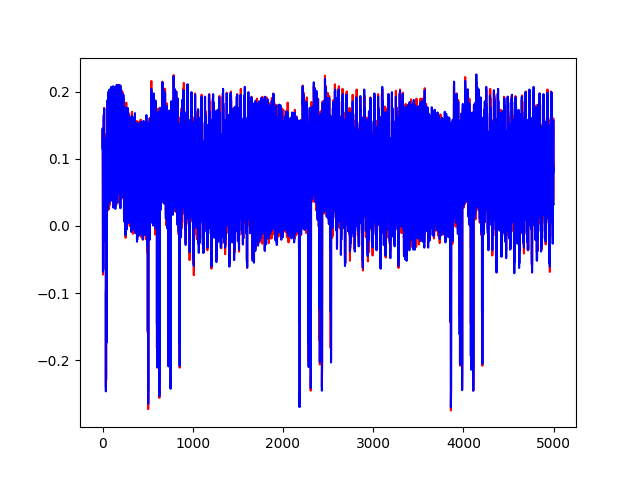

In [9]:
%matplotlib ipympl
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace_array[0], 'red')
plt.plot(trace_array[1], 'blue')
plt.show()

OK interesting - so we've got data! And what about the format of the input data?

In [10]:
print(textin_array[0])
print(textin_array[1])

CWbytearray(b'9e a9 37 01 06 2b 21 5c a1 9b 0e 47 d9 8d e5 03')
CWbytearray(b'9d 9d a6 23 d8 34 d6 60 bf de c9 0b 03 f0 9e 66')


## AES Guesser - One Byte

The attack now needs a way of splitting traces into two groups, depending on the state of a bit in our "guessed" value. We're going to start easy by guessing a single byte of the AES key at a time.

To start with - define the number of traces & number of points in each trace. You can use the following example code, just run this block:

In [11]:
numtraces = np.shape(trace_array)[0] #total number of traces
numpoints = np.shape(trace_array)[1] #samples per trace
print(numtraces, numpoints)

5000 5000


If you remember from the slides - our algorithm looks like this:    

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:
        
        one_list = empty list
        zero_list = empty list
        
        for trace_index in [0, 1, 2, 3, ..., numtraces]:
        
            input_byte = textin_array[trace_index][byte_to_attack]
            
            #Get a hypothetical leakage list - use aes_internal(guess, input_byte)          

            if hypothetical_leakage bit 0 is 1:
                append trace_array[trace_index] to one_list
            else:
                append trace_array[trace_index] to zero_list
                
        one_avg = average of one_list
        zero_avg = average of zero_list

        max_diff_value = maximum of ABS(one_avg - zero_avg)
        
To get the average of your `one_list` and `zero_list` you can use numpy:

    import numpy as np
    avg_one_list = np.asarray(one_list).mean(axis=0)

The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

To help you do some testing - let me tell you that the correct value of byte 0 is `0x2B`. You can use this to validate that your solution is working on the first byte. If you get stuck - see some hints below (but give it a try first).

What you should see is an output of the maximum value between the two average groups be higher for the `0x2B` value. For example, priting the maximum SAD value from an example loop looks like this for me:

    Guessing 28: 0.001397
    Guessing 29: 0.000927
    Guessing 2a: 0.001953
    Guessing 2b: 0.005278
    Guessing 2c: 0.000919
    Guessing 2d: 0.002510
    Guessing 2e: 0.001241
    Guessing 2f: 0.001242

Note the value of `0.005278` for `0x2B` - this is higher than the others which range from `0.000927` to `0.002510`.

In [12]:
import numpy as np
mean_diffs = np.zeros(256)
for guess in range(256):
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        input_byte = textin_array[trace_index][0]

        hypothetical_leakage = aes_internal(key=guess, inputdata=input_byte)

        if hypothetical_leakage & 0x01:
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])
    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)

    mean_diffs[guess] = np.max(abs(one_avg - zero_avg))
    print('Guessing {:0X}: {:f}'.format(guess, mean_diffs[guess]))

Guessing 0: 0.002567
Guessing 1: 0.001541
Guessing 2: 0.002328
Guessing 3: 0.001831
Guessing 4: 0.001997
Guessing 5: 0.002098
Guessing 6: 0.001975
Guessing 7: 0.001786
Guessing 8: 0.002534
Guessing 9: 0.001825
Guessing A: 0.002046
Guessing B: 0.002058
Guessing C: 0.001877
Guessing D: 0.001565
Guessing E: 0.002191
Guessing F: 0.001703
Guessing 10: 0.002066
Guessing 11: 0.002750
Guessing 12: 0.001873
Guessing 13: 0.001735
Guessing 14: 0.001878
Guessing 15: 0.003595
Guessing 16: 0.001717
Guessing 17: 0.001854
Guessing 18: 0.002149
Guessing 19: 0.002297
Guessing 1A: 0.001930
Guessing 1B: 0.001735
Guessing 1C: 0.001873
Guessing 1D: 0.002596
Guessing 1E: 0.002048
Guessing 1F: 0.001792
Guessing 20: 0.002426
Guessing 21: 0.002662
Guessing 22: 0.002039
Guessing 23: 0.002275
Guessing 24: 0.001579
Guessing 25: 0.001518
Guessing 26: 0.001904
Guessing 27: 0.002011
Guessing 28: 0.001925
Guessing 29: 0.001412
Guessing 2A: 0.003987
Guessing 2B: 0.004561
Guessing 2C: 0.002032
Guessing 2D: 0.002362
Gues

In [13]:
sorted_list = np.argsort(mean_diffs)[::-1]

for guess in sorted_list[0:20]:
    print('Guess {:0X}: {:1f}'.format(guess, mean_diffs[guess]))

Guess 2B: 0.004561
Guess 2A: 0.003987
Guess 15: 0.003595
Guess FE: 0.003423
Guess B2: 0.003341
Guess 68: 0.003123
Guess 96: 0.003115
Guess 4F: 0.003050
Guess D9: 0.002975
Guess B5: 0.002928
Guess 9F: 0.002928
Guess BF: 0.002918
Guess 40: 0.002916
Guess 4A: 0.002901
Guess BB: 0.002857
Guess FF: 0.002835
Guess 35: 0.002807
Guess 32: 0.002796
Guess BD: 0.002780
Guess B7: 0.002769


### Hint 1: General Program Flow

You can use the following general program flow to help you implement the outer loop above:

In [14]:
#Hint #1 - General Program Flow
import numpy as np
mean_diffs = np.zeros(256)

guessed_byte = 0

for guess in range(0, 256):
    
    one_list = []
    zero_list = []
    
    for trace_index in range(numtraces):
        #Inside here do the steps shown above
        pass
        
    #Do extra steps to average one_list and zero_list        

### Hint 2: Example of Two Different Key Guesses

We aren't fully going to give it away (see `SOLN` notebook if you want that), but here is how you can generate two differences, for `0x2B` and `0xFF`. If you're totally stuck you can use the following code to base what should be inside the loops on.

In [15]:
import numpy as np
mean_diffs = np.zeros(256)

### Code to do guess of byte 0 set to 0x2B
guessed_byte = 0
guess = 0x2B
   
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_2b = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0x2B: {:1}".format(mean_diffs_2b))

### Code to do guess of byte 0 set to 0xFF
guessed_byte = 0
guess = 0xFF
    
one_list = []
zero_list = []
    
for trace_index in range(numtraces):
    hypothetical_leakage = aes_internal(guess, textin_array[trace_index][guessed_byte])

    #Mask off the lowest bit - is it 0 or 1? Depending on that add trace to array
    if hypothetical_leakage & 0x01:        
        one_list.append(trace_array[trace_index])
    else:
        zero_list.append(trace_array[trace_index])
            
one_avg = np.asarray(one_list).mean(axis=0)
zero_avg = np.asarray(zero_list).mean(axis=0)
mean_diffs_ff = np.max(abs(one_avg - zero_avg))

print("Max SAD for 0xFF: {:1}".format(mean_diffs_ff))

Max SAD for 0x2B: 0.0045612229266706605
Max SAD for 0xFF: 0.002834902493968061


## Ranking Guesses

You'll also want to rank some of your guesses (we assume). This will help you identify the most likely value. The best way to do this is build a list of the maximum difference values for each key:

    mean_diffs = [0]*256

    for key_byte_guess_value in [0, 1, 2, 3, ... 253, 254, 255]:

        *** CODE FROM BEFORE***
        max_diff_value = maximum of ABS(one_avg - zero_avg)
        mean_diffs[key_byte_guess_value] = max_diff_value
        
If you modify your previous code, it will generate a list of maximum differences in a list. This list will look like:

    [0.002921, 0.001923, 0.005131, ..., 0.000984]
    
Where the *index* of the list is the value of the key guess. We can use `np.argsort` which generates a new list showing the *indicies* that would sort an original list (you should have learned about `argsort` in the previous lab too):

So for example, run the following to see it in action on the list `[1.0, 0.2, 3.4, 0.01]`:

In [16]:
np.argsort([1.0, 0.2, 3.4, 0.01])

array([3, 1, 0, 2])

This should return `[3, 1, 0, 2`] - that is the order of lowest to highest. To change from highest to lowest, remember you just add `[::-1]` at the end of it like `np.argsort([1.0, 0.2, 3.4, 0.01])[::-1]`.

Try using the `np.argsort` function to output the most likely key values from your attack.

## Plotting Differences

Before we move on - you should take a look at various plots of these differences. They will play in something called the *ghost peak* problem.

We're going to now define a function called `calculate_diffs()` that implements our attacks (you can replace this with your own function or keep this one for now):

In [17]:
def calculate_diffs(guess, byteindex=0, bitnum=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    one_list = []
    zero_list = []

    for trace_index in range(numtraces):
        hypothetical_leakage = aes_internal(guess, textin_array[trace_index][byteindex])

        #Mask off the requested bit
        if hypothetical_leakage & (1<<bitnum):
            one_list.append(trace_array[trace_index])
        else:
            zero_list.append(trace_array[trace_index])

    one_avg = np.asarray(one_list).mean(axis=0)
    zero_avg = np.asarray(zero_list).mean(axis=0)
    return abs(one_avg - zero_avg)

Try plotting the difference between various bytes. For byte 0, remember `0x2B` is the correct value. Zoom in on the plots and see how the correct key should have a much larger difference.

Sometimes we get *ghost peaks* which are incorrect peaks. So far we're assuming there is a single "best" solution for the key - we may need to get fancy and put a threshold whereby we have several candidates for the correct key. For now let's just plot a handful of examples:

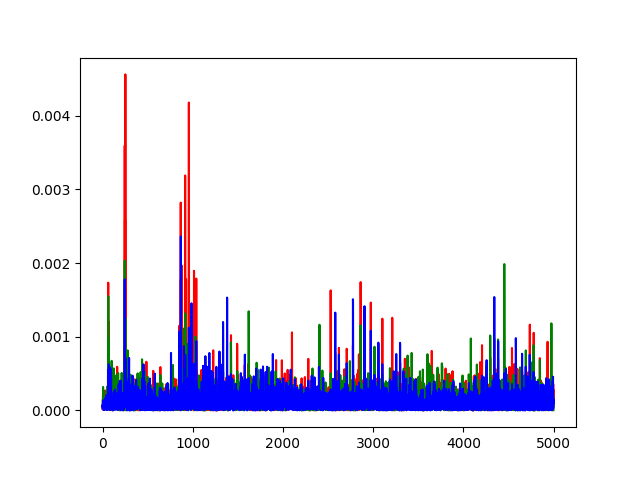

In [18]:
%matplotlib ipympl
import matplotlib.pylab as plt

plt.plot(calculate_diffs(0x2B), 'r')
plt.plot(calculate_diffs(0x2C), 'g')
plt.plot(calculate_diffs(0x2D), 'b')

Here is what it should look like:

You'll notice when we rank the bytes we just use the maximum value of any peak. There's lots more you could learn from these graphs, such as the location of the peak, or if there are multiple peaks in the graph. But for now we're just going to keep with the 

## AES Guesser - All Bytes

Alright - good job! You've got a single byte and some DPA plots up. Now let's move onward and guess *all* of the bytes.

Doing this requires a little more effort than before. Taking your existing guessing function, you're going to wrap a larger loop around the outside of it like this:

    for subkey in range(0,16):
        #Rest of code from before!
        

In [19]:
from tqdm import trange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

for subkey in trange(0, 16, desc="Attacking Subkey"):
    # ###################
    # Add your code here
    # ###################
    max_individual_diffs = [0] * 256
    for guess in range(256):
        diffs = calculate_diffs(guess,byteindex=subkey)
        max_individual_diffs[guess] = np.max(diffs)

    top_diffs = np.argsort(max_individual_diffs)[::-1]
        
    key_guess.append(top_diffs[0])

    print('Subkey {:d} - most likely {:X} (actual {:X})'.format(subkey, top_diffs[0], known_key[subkey]))

    print("Top 5 guesses:")
    for g in top_diffs[0:5]:
        print('{:0X} - Diff = {:f}'.format(g, max_individual_diffs[g])) 
        

Attacking Subkey:   6%|▋         | 1/16 [00:13<03:29, 13.96s/it]

Subkey 0 - most likely 2B (actual 2B)
Top 5 guesses:
2B - Diff = 0.004561
2A - Diff = 0.003987
15 - Diff = 0.003595
FE - Diff = 0.003423
B2 - Diff = 0.003341


Attacking Subkey:  12%|█▎        | 2/16 [00:27<03:13, 13.79s/it]

Subkey 1 - most likely 92 (actual 7E)
Top 5 guesses:
92 - Diff = 0.008009
77 - Diff = 0.007445
7E - Diff = 0.007078
AE - Diff = 0.006873
40 - Diff = 0.006842


Attacking Subkey:  19%|█▉        | 3/16 [00:41<02:59, 13.83s/it]

Subkey 2 - most likely 15 (actual 15)
Top 5 guesses:
15 - Diff = 0.005080
70 - Diff = 0.003805
14 - Diff = 0.003791
71 - Diff = 0.003040
F9 - Diff = 0.003037


Attacking Subkey:  25%|██▌       | 4/16 [00:55<02:45, 13.79s/it]

Subkey 3 - most likely 16 (actual 16)
Top 5 guesses:
16 - Diff = 0.007964
17 - Diff = 0.003816
72 - Diff = 0.003191
7D - Diff = 0.003156
73 - Diff = 0.002952


Attacking Subkey:  31%|███▏      | 5/16 [01:08<02:31, 13.77s/it]

Subkey 4 - most likely 28 (actual 28)
Top 5 guesses:
28 - Diff = 0.005353
29 - Diff = 0.003823
9C - Diff = 0.003401
94 - Diff = 0.003246
4D - Diff = 0.003208


Attacking Subkey:  38%|███▊      | 6/16 [01:22<02:17, 13.76s/it]

Subkey 5 - most likely AE (actual AE)
Top 5 guesses:
AE - Diff = 0.004883
CB - Diff = 0.003593
AF - Diff = 0.003497
CA - Diff = 0.003001
37 - Diff = 0.002902


Attacking Subkey:  44%|████▍     | 7/16 [01:36<02:04, 13.81s/it]

Subkey 6 - most likely 3E (actual D2)
Top 5 guesses:
3E - Diff = 0.007436
18 - Diff = 0.006429
7D - Diff = 0.006372
B7 - Diff = 0.006303
29 - Diff = 0.006264


Attacking Subkey:  50%|█████     | 8/16 [01:50<01:50, 13.83s/it]

Subkey 7 - most likely A6 (actual A6)
Top 5 guesses:
A6 - Diff = 0.005002
C3 - Diff = 0.003671
C2 - Diff = 0.003374
A7 - Diff = 0.003253
40 - Diff = 0.003182


Attacking Subkey:  56%|█████▋    | 9/16 [02:04<01:37, 13.88s/it]

Subkey 8 - most likely AB (actual AB)
Top 5 guesses:
AB - Diff = 0.004956
AA - Diff = 0.003324
7F - Diff = 0.003284
7E - Diff = 0.003219
CF - Diff = 0.002979


Attacking Subkey:  62%|██████▎   | 10/16 [02:18<01:23, 13.84s/it]

Subkey 9 - most likely F7 (actual F7)
Top 5 guesses:
F7 - Diff = 0.005361
F6 - Diff = 0.003233
92 - Diff = 0.003207
23 - Diff = 0.003085
5 - Diff = 0.002963


Attacking Subkey:  69%|██████▉   | 11/16 [02:32<01:09, 13.82s/it]

Subkey 10 - most likely 15 (actual 15)
Top 5 guesses:
15 - Diff = 0.007696
7E - Diff = 0.003799
14 - Diff = 0.003705
A8 - Diff = 0.003562
70 - Diff = 0.003468


Attacking Subkey:  75%|███████▌  | 12/16 [02:45<00:55, 13.82s/it]

Subkey 11 - most likely 64 (actual 88)
Top 5 guesses:
64 - Diff = 0.008737
6B - Diff = 0.007228
D1 - Diff = 0.006957
42 - Diff = 0.006864
58 - Diff = 0.006731


Attacking Subkey:  81%|████████▏ | 13/16 [02:59<00:41, 13.79s/it]

Subkey 12 - most likely 9 (actual 9)
Top 5 guesses:
9 - Diff = 0.004988
8 - Diff = 0.003670
95 - Diff = 0.003419
6D - Diff = 0.003360
6C - Diff = 0.003169


Attacking Subkey:  88%|████████▊ | 14/16 [03:13<00:27, 13.79s/it]

Subkey 13 - most likely CF (actual CF)
Top 5 guesses:
CF - Diff = 0.005164
AB - Diff = 0.003809
CE - Diff = 0.003589
AA - Diff = 0.003494
23 - Diff = 0.003196


Attacking Subkey:  94%|█████████▍| 15/16 [03:27<00:13, 13.81s/it]

Subkey 14 - most likely 4F (actual 4F)
Top 5 guesses:
4F - Diff = 0.004709
4E - Diff = 0.003946
9A - Diff = 0.003120
2B - Diff = 0.003002
2A - Diff = 0.002900


Attacking Subkey: 100%|██████████| 16/16 [03:40<00:00, 13.81s/it]

Subkey 15 - most likely 3C (actual 3C)
Top 5 guesses:
3C - Diff = 0.006392
3D - Diff = 0.003616
59 - Diff = 0.003209
58 - Diff = 0.003084
9B - Diff = 0.002897


🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳
Congrats - you did it!!!!

Hopefully the above worked - but we're going to go a little further to understand how to apply this in case it didn't work right away (or it almost worked).

## Ghost Peaks

Maybe the previous didn't actually recover the full key? No need to worry - there are a few reasons for this. One artifact of a DPA attack is you get another strong peak that isn't the correct key (which can be a ghost peak).

We're going to get into more efficient attacks later, but for now, let's look at some solutions:

* Increase the number of traces recorded.
* Change the targetted bit (& combine solutions from multiple bits).
* Window the input data.

The first one is the brute-force option: go from 2500 to 5000 or even 10000 power traces. As you add more data, you may find the problem is reduced. But real ghost peaks may not disappear, so we need to move onto other solutions.

Before we begin - we're going to give you a "known good" DPA attack script we're going to build on. This uses the `calculate_diffs()` function defined earlier.

Run the following block (will take a bit of time):

In [20]:
from tqdm import trange
import numpy as np

#Store your key_guess here, compare to known_key
key_guess = []
known_key = [0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c]

#Which bit to target
bitnum = 0

full_diffs_list = []

for subkey in trange(0, 16, desc="Attacking Subkey"):
    
    max_diffs = [0]*256
    full_diffs = [0]*256

    for bitnum in trange(8, desc='Testing bitnum'):
        for guess in range(0, 256):
            full_diff_trace = calculate_diffs(guess, subkey, bitnum)
            max_diffs[guess] = np.max(full_diff_trace)
            full_diffs[guess] = full_diff_trace
    
        #Get argument sort, as each index is the actual key guess.
        sorted_args = np.argsort(max_diffs)[::-1]
    
        #Keep most likely
        key_guess.append(sorted_args[0])
    
        #Print results
        print("Subkey %2d - most likely %02X (actual %02X)"%(subkey, sorted_args[0], known_key[subkey]))
    
        #Print other top guesses
        print(" Top 5 guesses: ")
        for i in range(0, 5):
            g = sorted_args[i]
            print("   %02X - Diff = %f"%(g, max_diffs[g]))
        if(key_guess[subkey] == known_key[subkey]):
            #Make copy of the list
            full_diffs_list.append(full_diffs[:])
            break
        else:
            if(bitnum < 7):
                key_guess.pop()
            print('Bitnum {:d} failed for subkey {:d}'.format(bitnum, subkey))
    print("\n")

Attacking Subkey:   6%|▋         | 1/16 [00:13<03:27, 13.81s/it]

Subkey  0 - most likely 2B (actual 2B)
 Top 5 guesses: 
   2B - Diff = 0.004561
   2A - Diff = 0.003987
   15 - Diff = 0.003595
   FE - Diff = 0.003423
   B2 - Diff = 0.003341




Subkey  1 - most likely 92 (actual 7E)
 Top 5 guesses: 
   92 - Diff = 0.008009
   77 - Diff = 0.007445
   7E - Diff = 0.007078
   AE - Diff = 0.006873
   40 - Diff = 0.006842
Bitnum 0 failed for subkey 1


Subkey  1 - most likely A5 (actual 7E)
 Top 5 guesses: 
   A5 - Diff = 0.008337
   D0 - Diff = 0.006637
   3F - Diff = 0.006620
   F9 - Diff = 0.006587
   C5 - Diff = 0.006551
Bitnum 1 failed for subkey 1


Subkey  1 - most likely F3 (actual 7E)
 Top 5 guesses: 
   F3 - Diff = 0.007615
   AE - Diff = 0.007079
   4B - Diff = 0.006597
   C3 - Diff = 0.006415
   96 - Diff = 0.006337
Bitnum 2 failed for subkey 1


Attacking Subkey:  12%|█▎        | 2/16 [01:08<08:53, 38.09s/it]

Subkey  1 - most likely 7E (actual 7E)
 Top 5 guesses: 
   7E - Diff = 0.045681
   BF - Diff = 0.007539
   E8 - Diff = 0.006828
   B8 - Diff = 0.006631
   01 - Diff = 0.006457




Attacking Subkey:  19%|█▉        | 3/16 [01:22<05:51, 27.00s/it]

Subkey  2 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 0.005080
   70 - Diff = 0.003805
   14 - Diff = 0.003791
   71 - Diff = 0.003040
   F9 - Diff = 0.003037




Attacking Subkey:  25%|██▌       | 4/16 [01:36<04:21, 21.78s/it]

Subkey  3 - most likely 16 (actual 16)
 Top 5 guesses: 
   16 - Diff = 0.007964
   17 - Diff = 0.003816
   72 - Diff = 0.003191
   7D - Diff = 0.003156
   73 - Diff = 0.002952




Attacking Subkey:  31%|███▏      | 5/16 [01:50<03:27, 18.86s/it]

Subkey  4 - most likely 28 (actual 28)
 Top 5 guesses: 
   28 - Diff = 0.005353
   29 - Diff = 0.003823
   9C - Diff = 0.003401
   94 - Diff = 0.003246
   4D - Diff = 0.003208




Attacking Subkey:  38%|███▊      | 6/16 [02:04<02:52, 17.22s/it]

Subkey  5 - most likely AE (actual AE)
 Top 5 guesses: 
   AE - Diff = 0.004883
   CB - Diff = 0.003593
   AF - Diff = 0.003497
   CA - Diff = 0.003001
   37 - Diff = 0.002902




Subkey  6 - most likely 3E (actual D2)
 Top 5 guesses: 
   3E - Diff = 0.007436
   18 - Diff = 0.006429
   7D - Diff = 0.006372
   B7 - Diff = 0.006303
   29 - Diff = 0.006264
Bitnum 0 failed for subkey 6


Subkey  6 - most likely 09 (actual D2)
 Top 5 guesses: 
   09 - Diff = 0.006934
   90 - Diff = 0.006542
   6F - Diff = 0.006311
   66 - Diff = 0.006186
   69 - Diff = 0.006159
Bitnum 1 failed for subkey 6


Subkey  6 - most likely 02 (actual D2)
 Top 5 guesses: 
   02 - Diff = 0.007239
   1F - Diff = 0.006885
   E7 - Diff = 0.006633
   5A - Diff = 0.006530
   6E - Diff = 0.006109
Bitnum 2 failed for subkey 6


Attacking Subkey:  44%|████▍     | 7/16 [02:59<04:25, 29.53s/it]

Subkey  6 - most likely D2 (actual D2)
 Top 5 guesses: 
   D2 - Diff = 0.044721
   13 - Diff = 0.007276
   14 - Diff = 0.007036
   44 - Diff = 0.007019
   5D - Diff = 0.006749




Attacking Subkey:  50%|█████     | 8/16 [03:12<03:16, 24.51s/it]

Subkey  7 - most likely A6 (actual A6)
 Top 5 guesses: 
   A6 - Diff = 0.005002
   C3 - Diff = 0.003671
   C2 - Diff = 0.003374
   A7 - Diff = 0.003253
   40 - Diff = 0.003182




Attacking Subkey:  56%|█████▋    | 9/16 [03:26<02:28, 21.15s/it]

Subkey  8 - most likely AB (actual AB)
 Top 5 guesses: 
   AB - Diff = 0.004956
   AA - Diff = 0.003324
   7F - Diff = 0.003284
   7E - Diff = 0.003219
   CF - Diff = 0.002979




Attacking Subkey:  62%|██████▎   | 10/16 [03:40<01:53, 18.85s/it]

Subkey  9 - most likely F7 (actual F7)
 Top 5 guesses: 
   F7 - Diff = 0.005361
   F6 - Diff = 0.003233
   92 - Diff = 0.003207
   23 - Diff = 0.003085
   05 - Diff = 0.002963




Attacking Subkey:  69%|██████▉   | 11/16 [03:54<01:26, 17.32s/it]

Subkey 10 - most likely 15 (actual 15)
 Top 5 guesses: 
   15 - Diff = 0.007696
   7E - Diff = 0.003799
   14 - Diff = 0.003705
   A8 - Diff = 0.003562
   70 - Diff = 0.003468




Subkey 11 - most likely 64 (actual 88)
 Top 5 guesses: 
   64 - Diff = 0.008737
   6B - Diff = 0.007228
   D1 - Diff = 0.006957
   42 - Diff = 0.006864
   58 - Diff = 0.006731
Bitnum 0 failed for subkey 11


Subkey 11 - most likely 53 (actual 88)
 Top 5 guesses: 
   53 - Diff = 0.008512
   C9 - Diff = 0.007374
   84 - Diff = 0.006680
   7E - Diff = 0.006520
   33 - Diff = 0.006177
Bitnum 1 failed for subkey 11


Subkey 11 - most likely 58 (actual 88)
 Top 5 guesses: 
   58 - Diff = 0.007169
   30 - Diff = 0.006926
   B7 - Diff = 0.006878
   45 - Diff = 0.006734
   BD - Diff = 0.006651
Bitnum 2 failed for subkey 11


Attacking Subkey:  75%|███████▌  | 12/16 [04:49<01:55, 28.85s/it]

Subkey 11 - most likely 88 (actual 88)
 Top 5 guesses: 
   88 - Diff = 0.045684
   7B - Diff = 0.008734
   4E - Diff = 0.007029
   07 - Diff = 0.006471
   1E - Diff = 0.006266




Attacking Subkey:  81%|████████▏ | 13/16 [05:03<01:12, 24.26s/it]

Subkey 12 - most likely 09 (actual 09)
 Top 5 guesses: 
   09 - Diff = 0.004988
   08 - Diff = 0.003670
   95 - Diff = 0.003419
   6D - Diff = 0.003360
   6C - Diff = 0.003169




Attacking Subkey:  88%|████████▊ | 14/16 [05:16<00:42, 21.10s/it]

Subkey 13 - most likely CF (actual CF)
 Top 5 guesses: 
   CF - Diff = 0.005164
   AB - Diff = 0.003809
   CE - Diff = 0.003589
   AA - Diff = 0.003494
   23 - Diff = 0.003196




Attacking Subkey:  94%|█████████▍| 15/16 [05:30<00:18, 18.87s/it]

Subkey 14 - most likely 4F (actual 4F)
 Top 5 guesses: 
   4F - Diff = 0.004709
   4E - Diff = 0.003946
   9A - Diff = 0.003120
   2B - Diff = 0.003002
   2A - Diff = 0.002900




Attacking Subkey: 100%|██████████| 16/16 [05:44<00:00, 21.52s/it]

Subkey 15 - most likely 3C (actual 3C)
 Top 5 guesses: 
   3C - Diff = 0.006392
   3D - Diff = 0.003616
   59 - Diff = 0.003209
   58 - Diff = 0.003084
   9B - Diff = 0.002897




In [21]:
print(key_guess)
print(known_key)

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]
[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]


This block should now print some *next top guesses* - in this case just the next top 5 guesses, but you can extend this if you wish. It's also keeping a copy of all the *difference* traces (unlike before where it threw them away).

### Plotting Peaks

After it runs, select a subkey that is either wrong or has very close "next best guesses". For example, the following shows the output for Subkey 5 is actually wrong - the correct guess (`0xAE`) has been ranked as option 5.

    Subkey  5 - most likely CB (actual AE)
     Top 5 guesses: 
       CB - Diff = 0.003006
       C5 - Diff = 0.002984
       AE - Diff = 0.002739
       3C - Diff = 0.002674
       2F - Diff = 0.002511

You can find the full diff in the `full_diffs_list` array. If you index this array it will give you every guess for a given subkey (for example `full_diffs_list[5]` is the 5th subkey guess outputs).

Using `full_diffs_list[N]` to get your selected subkey, plot the correct key by plotting `full_diffs_list[N][0xCORRECT]` in green as the *last* (so it appears on top). Plot a few other highly ranked guesses before that. In my example, this would look like:

    %matplotlib notebook
    import matplotlib.pylab as plt

    plt.plot(full_diffs_list[5][0xC5], 'r')
    plt.plot(full_diffs_list[5][0xCB], 'r')
    plt.plot(full_diffs_list[5][0xAE], 'g')

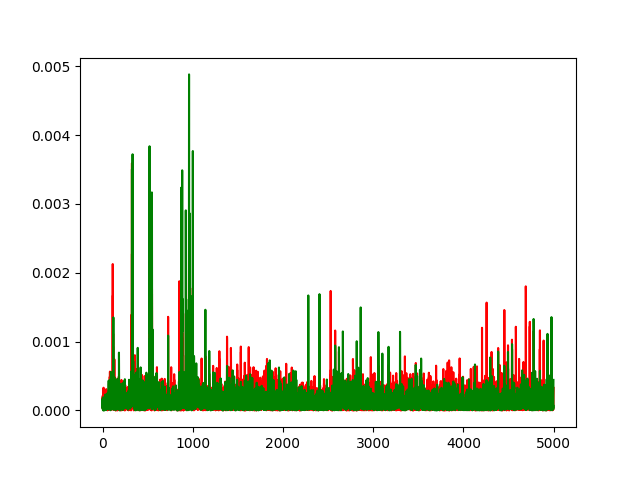

In [22]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(full_diffs_list[5][0xC5], 'r')
plt.plot(full_diffs_list[5][0xCB], 'r')
plt.plot(full_diffs_list[5][0xAE], 'g')

Zoom in on the window, and you should notice there is a location where the correct peak is *higher* than the incorrect peaks. If you want to plot all the traces (this will get slow!) for a given trace, we can do so as the following:

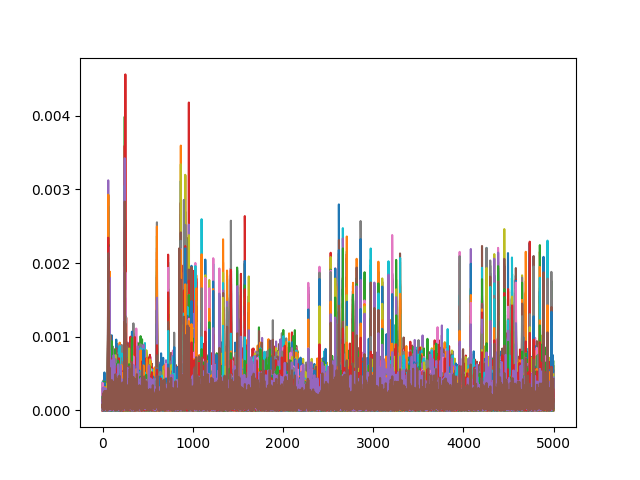

In [23]:
plt.figure()
subkey = 0
for guess in range(0, 256):
    plt.plot(full_diffs_list[subkey][guess])
plt.show()

Depending on your hardware, the previous may show a single nice large spike, or multiple large spikes. If we have the ghost peak problem you've probably got multiple spikes. The incorrect peaks may trail behind the correct locations -- we can first plot the correct locations by looking at the known key. The following will do that:

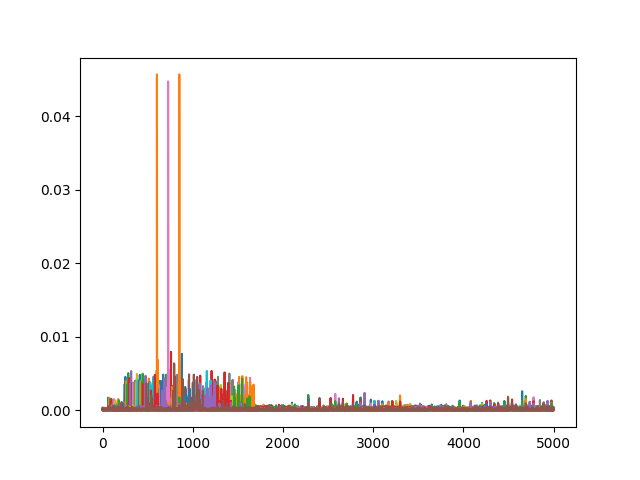

In [24]:
plt.figure()
for subkey in range(0, 16):
    plt.plot(full_diffs_list[subkey][known_key[subkey]])
plt.show()

### Windowing Peaks

The final trick here - see if there is some way to "window" the data that could be useful. For example, looking at the peaks you might notice that the correct peaks are always coming at 60 cycle offsets, with the first peak around sample 1100 (these will be different for your hardware).

So we could modify the loop to only look at differences after this point:

    for guess in range(0, 256):
        full_diff_trace = calculate_diffs(guess, subkey, bitnum)
        full_diff_trace = full_diff_trace[(1010 + subkey*60):]
        max_diffs[guess] = np.max(full_diff_trace)
        full_diffs[guess] = full_diff_trace
        
Copy the full DPA attack here - and try it out! See if you can get the correct key to come out for every byte.

In [25]:
target.dis()
scope.dis()

True

### Attacking Other Bits

So far we only looked at bit 0 $-$ but there are more bits involved here! You can first just try another bit that might be present, maybe they simply work better?

But you can also combine multiple bits by creating a most likely solution that applies across *all* bits.

The first one is easy to try out, as we defined the bit to attack in the previous script

The second option is a little more advanced. You can give it a try $-$ but in practice, if you are trying to combine multiple bits, a more effective method called the CPA attack will be used.

## Conclusions & Next Steps

You've now seen how a DPA attack can be performed using a basic Python script. We'll experience much more effective attacks once we look at the CPA attack.

If you want to perform these attacks in practice, the Python code here isn't the most efficient! We'll look at faster options in later courses.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>